In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

start = 0
end = 10
res = 100
grid = np.linspace(start, end, res)
dx = (end - start) / res

X = 64
dx = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)

# test case with dirichlet BC

u = -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

INT = np.s_[1:-1, 1:-1]
XIN = np.s_[2:  , 1:-1]
XMI = np.s_[ :-2, 1:-1]
YIN = np.s_[1:-1, 2:  ]
YMI = np.s_[1:-1,  :-2]


def div(f):
    return (f[XIN][..., 0] - f[XMI][..., 0] + f[YIN][..., 1] - f[YMI][..., 1])


def lap(f, h):
    return (f[XIN] + f[XMI] + f[YIN] + f[YMI] - 4.0 * f[INT]) * 1.0/(h*h)


def prepare_rhs(rho, h):
    return rho[INT] * (h*h)


# ∇² (phi + e) = rho
# ∇²phi + ∇²e = rho
# ∇²e = rho - ∇²phi
# ∇²e = r
def compute_residual(phi, rho, h):
    r = np.zeros_like(phi)
    r[INT] = rho[INT] - lap(phi, h)
    return r


def restriction_2_2(r, X):
    reduced = np.zeros((X, X))
    # reduced[:] = r[::2, ::2]
    reduced[:] = 0.25 * r[0::2, 0::2] + 0.25 * r[0::2, 1::2] + 0.25 * r[1::2, 0::2] + 0.25 * r[1::2, 1::2]
    
    
    # reduced[:-1, -1] = 0
    #     + 1/6.0 * r[0:-2:2, 0:-2:2]
    #     + 1/6.0 * r[0::2, 0::2]

    return reduced

def restriction_mix_3_3(r, X):
    reduced = np.zeros((X, X))
    reduced[:] = 0.25 * r[0::2, 0::2] + 0.25 * r[0::2, 1::2] + 0.25 * r[1::2, 0::2] + 0.25 * r[1::2, 1::2]
    reduced[:-1, :-1] = (
          1/9.0 * r[0:-2:2, 0:-2:2] 
        + 1/9.0 * r[1:-1:2, 0:-2:2]
        + 1/9.0 * r[2:  :2, 0:-2:2]
        + 1/9.0 * r[0:-2:2, 1:-1:2] 
        + 1/9.0 * r[1:-1:2, 1:-1:2]
        + 1/9.0 * r[2:  :2, 1:-1:2]
        + 1/9.0 * r[0:-2:2, 2:  :2] 
        + 1/9.0 * r[1:-1:2, 2:  :2]
        + 1/9.0 * r[2:  :2, 2:  :2]
    )
    return reduced
    
def prolongation_linear(e, X):
    EX = X // 2
    prolong = np.zeros((X, X))
    prolong[0::2, 0::2] = e[:]
    
    prolong[0:X:2, 1:X-1:2] = (e[0:EX:1, 0:EX-1:1] + e[0:EX:1, 1:EX:1]) / 2.0
    prolong[0:X:2, X-1] = e[0:EX:1, EX-1]

    
    prolong[1:X-1:2, 0:X:2,] = (e[0:EX-1:1, 0:EX:1] + e[1:EX:1, 0:EX:1]) / 2.0
    prolong[X-1, 0:X:2] = e[EX-1, 0:EX:1]

    
    prolong[1:X-1:2, 1:X-1:2] = (e[0:EX-1:1, 0:EX-1:1] + e[1:EX:1, 1:EX:1]) / 2.0
    prolong[X-1, X-1] = e[EX-1, EX-1]
    prolong[X-1, 1:X:2] = e[EX-1, :EX:1]
    prolong[1:X:2, X-1] = e[:EX:1, EX-1]
    
    # prolong[0::2, 1::2] = e[:]
    # prolong[1::2, 0::2] = e[:]
    return prolong

def restriction_fw(r, X):
    r_coarse = np.zeros((X, X))
    for i in range(1, X-1):
        for j in range(1, X-1):
            i_f, j_f = 2*i, 2*j
            r_coarse[i,j] = (
                4*r[i_f, j_f] +
                2*(r[i_f-1, j_f] + r[i_f+1, j_f] + r[i_f, j_f-1] + r[i_f, j_f+1]) +
                (r[i_f-1, j_f-1] + r[i_f-1, j_f+1] + r[i_f+1, j_f-1] + r[i_f+1, j_f+1])
            ) / 16.0

    # BC
    r_coarse[0,:] = r_coarse[1,:]
    r_coarse[-1,:] = r_coarse[-2,:]
    r_coarse[:,0] = r_coarse[:,1]
    r_coarse[:,-1] = r_coarse[:,-2]
    
    return r_coarse


def prolongation_fw(e, X):
    """
    Bilinear prolongation (coarse -> fine)
    e: coarse error, shape (X//2, X//2)
    X: fine grid size (output)
    returns: fine error of shape (X, X)
    """
    EX = e.shape[0]
    e_fine = np.zeros((X, X))
    
    # Coarse points -> fine grid
    e_fine[0::2,0::2] = e[:,:]
    
    # Interpolate horizontally
    e_fine[0::2,1:-1:2] = 0.5*(e[:,:-1] + e[:,1:])
    
    # Interpolate vertically
    e_fine[1:-1:2,0::2] = 0.5*(e[:-1,:] + e[1:,:])
    
    # Interpolate diagonally
    e_fine[1:-1:2,1:-1:2] = 0.25*(e[:-1,:-1] + e[1:,:-1] + e[:-1,1:] + e[1:,1:])
    
    # BC
    e_fine[0,:] = e_fine[1,:]
    e_fine[-1,:] = e_fine[-2,:]
    e_fine[:,0] = e_fine[:,1]
    e_fine[:,-1] = e_fine[:,-2]
    
    return e_fine

In [2]:
h = 1 / X
domain = np.linspace(0, 1, X)
x, y = np.meshgrid(domain, domain)
u = -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

def set_bc(phi):
    phi[0,:] = phi[1,:]
    phi[-1,:] = phi[-2,:]
    phi[:,0] = phi[:,1]
    phi[:,-1] = phi[:,-2]

p = np.random.rand(X, X)
set_bc(p)

r0 = np.linalg.norm(compute_residual(p, u, h))

df = pd.DataFrame(columns=["time", "residual", "version", "run_id"])

def prepare_bench_iter():
    global p
    global r0
    
    p = np.random.rand(X, X)
    p[0, :] = 0
    p[-1, :] = 0
    p[1:-1, 0] = 0
    p[1:-1, -1] = 0
    
    r0 = np.linalg.norm(compute_residual(p, u, h))



In [46]:
import time

samples = []
times = []
start_time = 0
valid_shape = (X, X)


def start_sampling():
    global samples
    global times
    global start_time
    
    samples = []
    times = []
    start_time = time.perf_counter()



def add_sample(phi, rho, h):
    if phi.shape != valid_shape: return
    curr = time.perf_counter() - start_time
    times.append(curr)
    samples.append(np.linalg.norm(compute_residual(phi, rho, h)) / r0)
    

def solve_poisson_jacobi(phi, rho, h, iters):
    phi_next = np.zeros_like(phi)
    for i in range(iters):
        phi_next[INT] = 1/4 * (phi[XIN] + phi[XMI] + phi[YIN] + phi[YMI] - rho[INT] * h * h)
        phi, phi_next = phi_next, phi
        set_bc(phi)
        add_sample(phi, rho, h)
    
    return phi

DEBUG = False

# ∇² phi (r) = rho (r) -> phi
def solve_poisson_mg(phi, rho, h, X, rec, smooth, full, restriction, prolongation):

    if rec <= 1:

        # Final coarse full solve:
        solve_poisson_jacobi(phi, rho, h, full)
        
        return phi

    # ∇² phi* = rho
    # phi* = phi + e
    # ∇² (phi + e) = rho
    # ∇²phi + ∇²e = rho
    # ∇²e = rho - ∇²phi
    # ∇²e = residual

    if DEBUG:
        plt.title(f"[{rec}]: in phi")
        plt.imshow(phi)
        plt.colorbar()
        plt.show()
    
    # pre smoothing
    solve_poisson_jacobi(phi, rho, h, smooth)
    if DEBUG:
        plt.title(f"[{rec}]: smoothed phi")
        plt.imshow(phi)
        plt.colorbar()
        plt.show()
    
    # ∇²e = rho - ∇²phi
    # ∇²e = residual
    residual = compute_residual(phi, rho, h)
    if DEBUG:
        plt.title(f"[{rec}]: residual")
        plt.imshow(residual)
        plt.colorbar()
        plt.show()
    rhs = restriction(residual,  X // 2)

    if DEBUG:
        plt.title(f"[{rec}]: rhs")
        plt.imshow(rhs)
        plt.colorbar()
        plt.show()

    e = np.zeros((X // 2, X // 2))
    # Solve: ∇²e = residual
    e = solve_poisson_mg(e, rhs, h * 2, X // 2, rec - 1, smooth, full, restriction, prolongation)
    # print(np.linalg.norm(compute_residual(e, rhs, h)))
    # upsample
    if DEBUG:
        plt.title(f"[{rec}]: E solved pre prol")
        plt.imshow(e)
        plt.colorbar()
        plt.show()
    e = prolongation(e, X)
    if DEBUG:
        plt.title(f"[{rec}]: E solved post prol")
        plt.imshow(e)
        plt.colorbar()
        plt.show()

        plt.title(f"[{rec}]: Phi")
        plt.imshow(phi)
        plt.colorbar()
        plt.show()

    # phi* = phi + e
    # print(np.linalg.norm(compute_residual(phi, rho, h)))
    # print(np.linalg.norm(compute_residual(e, residual, h)))
    
    # print(np.sum(compute_residual(phi + e, rho, h) - compute_residual(e, residual, h)))
    phi = phi + e
    set_bc(phi)
    # print(np.linalg.norm(compute_residual(phi, rho, h)))
    add_sample(phi, rho, h)
    if DEBUG:
        plt.title(f"[{rec}]: Phi with e ")
        plt.imshow(phi)
        plt.colorbar()
        plt.show()

    # post smoothing
    solve_poisson_jacobi(phi, rho, h, smooth)
    return phi

def benchmark(func, legend, iters=15, warmup=3):
    global df
    for i in range(warmup):
        start_sampling()
        func()
    for i in range(iters):
        start_sampling()
        func()
        df = pd.concat(
            [df, pd.DataFrame({"time": times, "residual": samples, "version": legend, "run_id":i})]
        )
        


In [47]:
solve_poisson_mg(p.copy(), u, h, X, 4, 10, 300, restriction_fw, prolongation_fw)

array([[12.41610621, 12.41610621, 12.41877296, ..., 12.4055723 ,
        12.40648713, 12.40648713],
       [12.41610621, 12.41610621, 12.41877296, ..., 12.4055723 ,
        12.40648713, 12.40648713],
       [12.41864305, 12.41864305, 12.41861035, ..., 12.40463251,
        12.40586675, 12.40586675],
       ...,
       [12.53404981, 12.53404981, 12.53553518, ..., 12.54157835,
        12.54625802, 12.54625802],
       [12.53168985, 12.53168985, 12.53471202, ..., 12.54291598,
        12.55114631, 12.55114631],
       [12.53168985, 12.53168985, 12.53471202, ..., 12.54291598,
        12.55114631, 12.55114631]], shape=(64, 64))

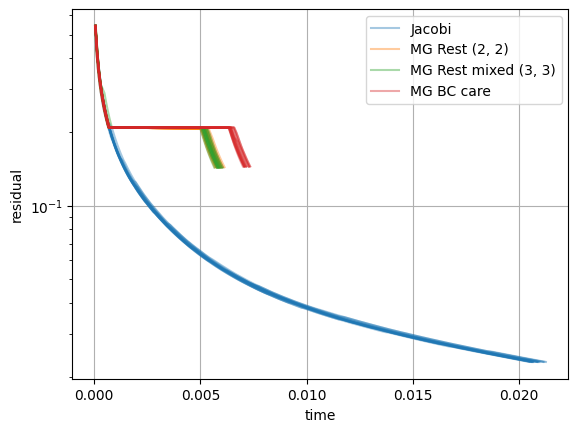

In [48]:
df = pd.DataFrame(columns=["time", "residual", "version", "run_id"])
benchmark(lambda: solve_poisson_jacobi(p.copy(), u, h, 300), "Jacobi")
# benchmark(lambda: solve_poisson_mg(p.copy(), u, h, X, 2, 10, 300, restriction_2_2, prolongation_linear), "MG Rest (2, 2)")
# benchmark(lambda: solve_poisson_mg(p.copy(), u, h, X, 2, 10, 300, restriction_mix_3_3, prolongation_linear), "MG Rest mixed (3, 3)")
benchmark(lambda: solve_poisson_mg(p.copy(), u, h, X, 2, 0, 300, restriction_fw, prolongation_fw), "MG BC care")


sns.lineplot(x="time", y="residual", hue="version", units="run_id", estimator=None, alpha=0.4, data=df)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()